# Universal Sentence Encoder
The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks. It is trained on a variety of data sources to learn for a wide variety of tasks. The sources are Wikipedia, web news, web question-answer pages, and discussion forums. The input is a variable-length English text and the output is a 512-dimensional vector.

In [90]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re
import string
import nltk

In [25]:
data = pd.read_json('bq_2018_top5SIC.json', lines=True)

In [26]:
df = data[['reportingDate', 'name', 'coDescription', 'SIC', 'SIC_desc']]

## Data Cleaning
#### - Normalization
#### - Remove Stopwords
#### - Lemmatization

In [27]:
#strip any left over html code
def clean_data_fn(insrt_data):
    
    clean_data = []
    
    for idx, ele in insrt_data.iterrows():
        if "https://www.sec.gov/Archives/edgar/data/" in ele[2]:
            pass
        else:
            clean_txt = re.compile('<.*?>')
            
            pos = 0
            
            desc = re.sub(clean_txt,'',ele["coDescription"]).replace(u'\xa0', u' ').replace("   ", "").replace("'", "").replace('"','')
            
            desc = desc.lower()
            
            if re.search('<', desc):
                pos = re.search('<', desc).start()
            
            desc = desc[:pos]
            
            if (desc.find("business") == -1): # didnt find it then look for next
                if(desc.find("business.") == -1): # didnt find it then just remove anything after "<" if at all
                    desc = desc[6 : ( desc.rfind("<") )]

                else: # found "Business.", remove everything before it
                    desc =  desc[( desc.find("business.") + 9 ) : ( desc.rfind("<") ) ]
            else:
                desc = desc[( desc.find("business") + 8 ) : ( desc.rfind("<") ) ]
            
            # remove leading white space and punctuation
            desc = re.sub(r'[\.\?\!\,\:\;\"]', '', desc).strip()
            
            # remove the non-letters
            desc = ''.join([x for x in desc if x in string.ascii_letters + '\'- '])
                
            new_data = pd.Series([ele[0], ele[1], desc, ele[3], ele[4]], index = insrt_data.columns)
            
            if len(desc)<250:
                pass
            else:
                clean_data.append(new_data)
    return(pd.DataFrame(clean_data))

df = clean_data_fn(df)
df

,reportingDate,name,coDescription,SIC,SIC_desc
0,2018-02-01,"MONGODB, INC.",overviewmongodb is the leading modern general ...,7372,Prepackaged Software (mass reproduction of sof...
1,2018-02-01,SALESFORCE COM INC,overviewsalesforce is a global leader in custo...,7372,Prepackaged Software (mass reproduction of sof...
2,2018-02-01,SPLUNK INC,overviewsplunk provides innovative software so...,7372,Prepackaged Software (mass reproduction of sof...
3,2018-02-01,"OKTA, INC.",overview okta is the leading independent provi...,7372,Prepackaged Software (mass reproduction of sof...
4,2018-02-01,VEEVA SYSTEMS INC,overview veeva is a leading provider of indust...,7372,Prepackaged Software (mass reproduction of sof...
...,...,...,...,...,...
668,2019-01-01,"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",organizationwe were incorporated on december ...,6798,Real Estate Investment Trusts
669,2019-01-01,"CYCLACEL PHARMACEUTICALS, INC.",the following business section contains forwar...,2834,Pharmaceutical Preparations
670,2019-01-01,ZOETIS INC.,productscosts and expenses costs of sales cons...,2834,Pharmaceutical Preparations
671,2019-01-01,"STAG INDUSTRIAL, INC.",certain definitionsin this reportwe define gaa...,6798,Real Estate Investment Trusts


In [ ]:
## Remove stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def removeStopWords(description):
    text_tokens = word_tokenize(description)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    return (" ").join(tokens_without_sw)

df["coDescription"] = df["coDescription"].apply(removeStopWords)
df["coDescription"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maryx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None
    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:                        
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

lemma_desc = df["coDescription"].apply(lemmatize_sentence)
df["coDescription_lemmatized"] = lemma_desc
df["coDescription_lemmatized"]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maryx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maryx\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maryx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maryx\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0      overviewmongodb be the lead modern general pur...
1      overviewsalesforce be a global leader in custo...
2      overviewsplunk provide innovative software sol...
3      overview okta be the lead independent provider...
4      overview veeva be a lead provider of industry ...
                             ...                        
668    organizationwe be incorporate on december as a...
669    the following business section contain forward...
670    productscosts and expense cost of sale consist...
671    certain definitionsin this reportwe define gaa...
672    the word equinix we our ours us and the compan...
Name: coDescription_lemmatized, Length: 673, dtype: object

In [ ]:
ADD LEMMATIZATION

### Training

In [51]:
import tensorflow_hub as hub
!pip3 install seaborn
import seaborn as sns
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

     ------------------------------------ 292.8/292.8 KB 157.2 kB/s eta 0:00:00
     ---------------------------------------- 7.2/7.2 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 37.0/37.0 MB 1.3 MB/s eta 0:00:00
     ------------------------------------ 895.5/895.5 KB 393.4 kB/s eta 0:00:00
     ---------------------------------------- 3.2/3.2 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 52.1/52.1 KB 1.4 MB/s eta 0:00:00
module %s loaded


In [52]:
embeddings = embed(df["coDescription_lemmatized"])
embeddings

<tf.Tensor: shape=(673, 512), dtype=float32, numpy=
array([[-0.04806986, -0.04807194, -0.04713878, ...,  0.04806738,
        -0.04807194, -0.03848716],
       [-0.04852239, -0.04856564, -0.02313868, ...,  0.03850256,
        -0.04856566, -0.04086569],
       [-0.04603694, -0.04770311, -0.04761591, ...,  0.04770311,
        -0.04770311, -0.04760274],
       ...,
       [-0.04546397, -0.04546409, -0.04546409, ..., -0.04521574,
        -0.04546206,  0.03687175],
       [-0.04769762, -0.05083709,  0.0207254 , ..., -0.00205691,
         0.04269946,  0.05053872],
       [-0.04710683, -0.04711295, -0.04701316, ...,  0.03848233,
        -0.04711295, -0.04710338]], dtype=float32)>

## Plotting

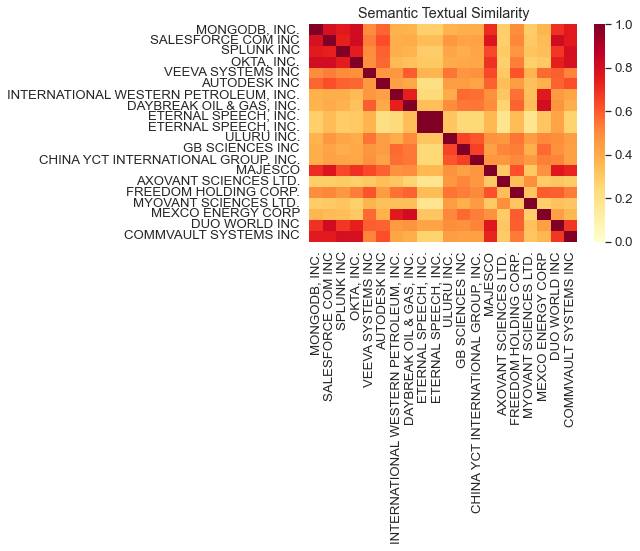

In [59]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(df["name"][:20],embeddings[:20], 90)

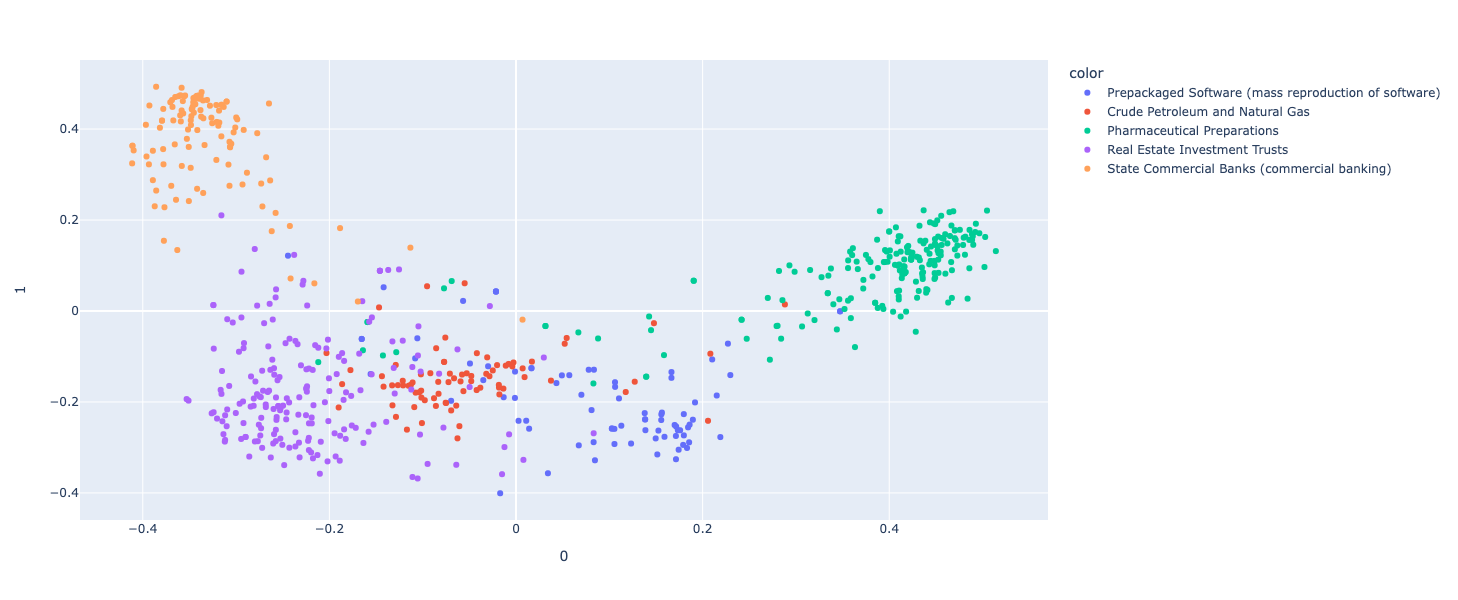

In [63]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Referenced from my CSCD25 course
def visualize_pca(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    pca = PCA(n_components = 50)
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = multi_index)
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, hover_data={"name": pca_embedding.index.get_level_values(0),
                                                              "industry": pca_embedding.index.get_level_values(1)},
                     color = pca_embedding.index.get_level_values(1), width=1200, height=600)
    fig.show()
    
    return [pca, pca_embedding]

plot_pca = visualize_pca(embeddings, df.loc[:,["name","SIC_desc"]])

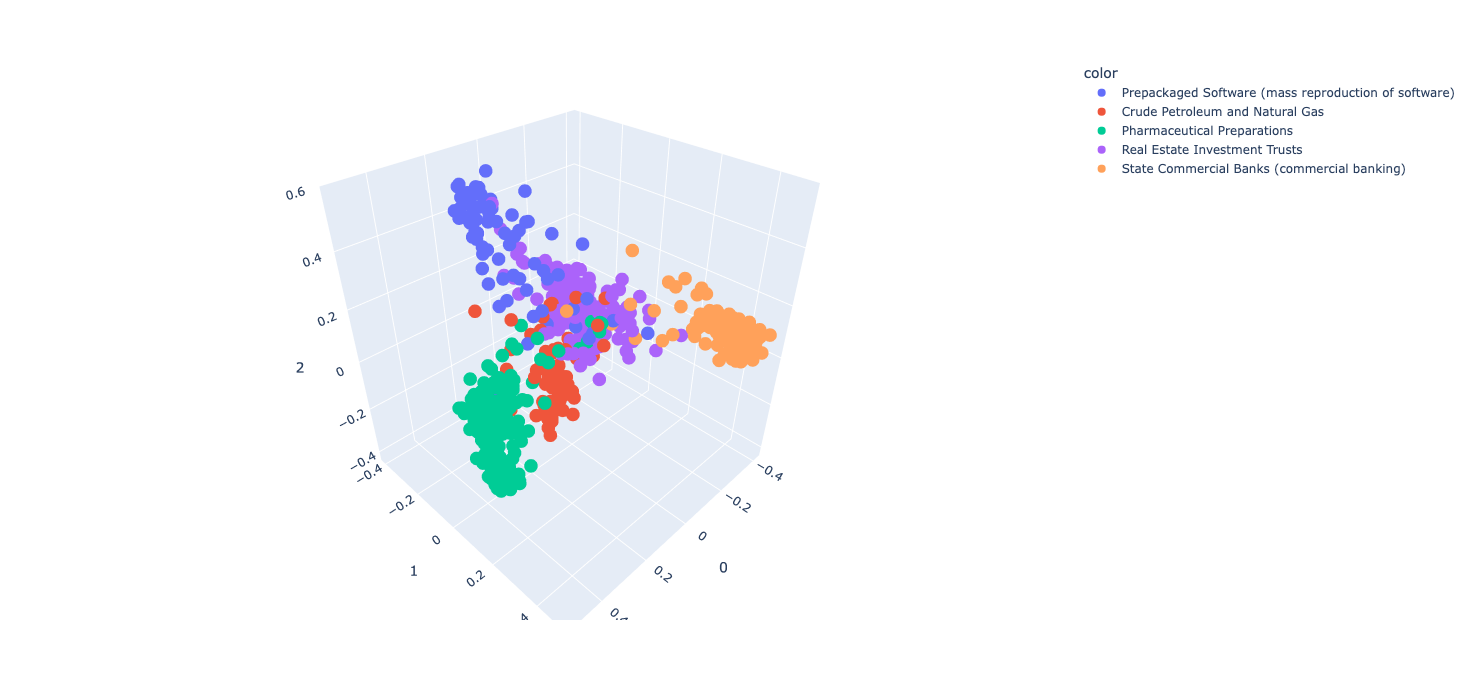

In [64]:
fig = px.scatter_3d(plot_pca[1], x =0 , y = 1, z = 2, hover_data={"name": plot_pca[1].index.get_level_values(0),
                                                              "industry": plot_pca[1].index.get_level_values(1)},
                    color = plot_pca[1].index.get_level_values(1), width=1200, height=700)
fig.show()

In [66]:
for i in range(len(embeddings)):
    
corr = np.inner(embeddings, embeddings)
len(corr)

673

In [70]:
embedding_matrix = pd.DataFrame(embeddings)
embedding_matrix.index = df["name"]
embedding_matrix

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
name,,,,,,,,,,,,,,,,,,,,,
"MONGODB, INC.",-0.048070,-0.048072,-0.047139,0.048072,-0.032919,0.035513,-0.034954,-0.048064,0.048072,-0.048072,...,-0.048049,-0.048072,-0.048072,0.019604,0.047635,-0.047770,0.047052,0.048067,-0.048072,-0.038487
SALESFORCE COM INC,-0.048522,-0.048566,-0.023139,0.048566,-0.048445,-0.000439,0.006797,-0.048563,0.047790,-0.048566,...,-0.047556,-0.048566,-0.048566,0.008412,0.048369,-0.041014,0.047619,0.038503,-0.048566,-0.040866
SPLUNK INC,-0.046037,-0.047703,-0.047616,0.047703,-0.047692,-0.047606,-0.047695,-0.047622,0.047693,-0.047610,...,-0.045693,-0.047703,-0.047703,-0.047339,0.047684,-0.047685,0.047702,0.047703,-0.047703,-0.047603
"OKTA, INC.",-0.047953,-0.048515,-0.020171,0.048526,-0.047487,0.048520,-0.014416,-0.045803,0.048011,-0.048473,...,-0.048522,-0.048526,-0.048526,0.005329,0.048335,-0.047663,0.047916,0.048500,-0.048526,-0.047204
VEEVA SYSTEMS INC,-0.045744,-0.045744,-0.045744,0.045744,-0.043273,0.045744,-0.045744,-0.045744,0.045744,-0.045744,...,-0.045744,-0.045744,-0.045744,-0.045134,-0.045744,0.041242,0.045744,0.045143,-0.045744,-0.030963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",-0.031146,-0.051230,0.014364,0.050921,0.050742,0.050692,0.036193,-0.051215,0.051228,-0.051230,...,-0.035835,-0.051230,-0.050045,0.035423,-0.047332,0.051230,0.036582,0.042016,0.030432,0.036613
"CYCLACEL PHARMACEUTICALS, INC.",-0.046823,-0.046826,-0.008361,0.040487,-0.046825,-0.046810,0.046397,-0.046826,0.046826,-0.046825,...,-0.046826,-0.046826,-0.045864,-0.046826,0.024175,-0.046804,-0.046161,0.046749,-0.046826,-0.046826
ZOETIS INC.,-0.045464,-0.045464,-0.045464,-0.029985,0.045464,0.045116,-0.045464,-0.045464,0.045464,-0.045464,...,-0.023494,-0.045464,0.002982,-0.045463,-0.045464,0.045460,0.045464,-0.045216,-0.045462,0.036872


## Similarity Matrix
USE gives normalized embeddings, so the inner product of encodings can be treated as a similarity matrix.

In [87]:
dot_product = np.matmul(embedding_matrix, embedding_matrix.T)
np.fill_diagonal(dot_product.values, 0)

C:\Users\maryx\AppData\Local\Temp\ipykernel_17396\1286590676.py:1: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.



In [88]:
dot_product.index = df["SIC_desc"]
dot_product.columns = df["SIC_desc"]
dot_product_df = pd.DataFrame(dot_product.idxmax(axis=1))
dot_product_df.reset_index(level=0, inplace=True)
dot_product_df.columns = ["desc1","desc2"]
dot_product_df

,desc1,desc2
0,Prepackaged Software (mass reproduction of sof...,Prepackaged Software (mass reproduction of sof...
1,Prepackaged Software (mass reproduction of sof...,Prepackaged Software (mass reproduction of sof...
2,Prepackaged Software (mass reproduction of sof...,Prepackaged Software (mass reproduction of sof...
3,Prepackaged Software (mass reproduction of sof...,Prepackaged Software (mass reproduction of sof...
4,Prepackaged Software (mass reproduction of sof...,Pharmaceutical Preparations
...,...,...
668,Real Estate Investment Trusts,Real Estate Investment Trusts
669,Pharmaceutical Preparations,Pharmaceutical Preparations
670,Pharmaceutical Preparations,Crude Petroleum and Natural Gas
671,Real Estate Investment Trusts,Real Estate Investment Trusts


In [ ]:
print("Percentage of correct category predictions: ")
print(np.sum(np.where(dot_product_df.iloc[:,1] == dot_product_df.iloc[:,0], 1, 0))/len(embeddings))